### Prof. Pedram Jahangiry


![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center) 

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_Learning-USU/blob/main/Lectures%20and%20codes/DL%20Spring%202023/Module%206-%20Deep%20Sequence%20Modeling/python/Module%206-%20NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 



## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 6: Deep Sequence Modeling (Univariate timeseries forecasting)

Can we predict stock market returns with LSTM? 

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow first: https://www.tensorflow.org/install


In [1]:
import tensorflow 
tensorflow.__version__

'2.12.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [3]:
stocks = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/yfinance.csv", index_col=0, header=[0,1])
stocks.head()

Adj Close                                                 \
                 AAPL         GLD       MSFT         QQQ         SPY   
Date                                                                   
2018-01-02  40.950497  125.150002  80.940392  153.123489  246.766678   
2018-01-03  40.943367  124.820000  81.317093  154.611298  248.327499   
2018-01-04  41.133541  125.459999  82.032768  154.881836  249.374115   
2018-01-05  41.601864  125.330002  83.049835  156.437332  251.035934   
2018-01-08  41.447350  125.309998  83.134598  157.045990  251.495041   

                                      Close                         ...  \
                 TSLA        USO       AAPL         GLD       MSFT  ...   
Date                                                                ...   
2018-01-02  21.368668  96.559998  43.064999  125.150002  85.949997  ...   
2018-01-03  21.150000  98.720001  43.057499  124.820000  86.349998  ...   
2018-01-04  20.974667  98.959999  43.257500  125.459999  87.110001  ...   
2018-01-05  21.105333  98.480003  43.750000  125.330002  88.190002  ...   
2018-01-08  22.427334  99.040001  43.587502  125.309998  88.279999  ...   

                  Open                           Volume                      \
                   SPY       TSLA        USO       AAPL       GLD      MSFT   
Date                                                                          
2018-01-02  267.839996  20.799999  96.559998  102223600  11762500  22483800   
2018-01-03  268.959991  21.400000  97.360001  118071600   7904300  26061400   
2018-01-04  271.200012  20.858000  98.639999   89738400   7329700  21912000   
2018-01-05  272.510010  21.108000  98.239998   94640000   5739900  23407100   
2018-01-08  273.309998  21.066668  98.480003   82271200   3566700  22113000   

                                                    
                 QQQ       SPY       TSLA      USO  
Date                                                
2018-01-02  32573300  86655700   65283000  1497588  
2018-01-03  29383600  90070400   67822500  2156150  
2018-01-04  24776100  80636400  149194500  1480988  
2018-01-05  26992300  83524000   68868000  1609888  
2018-01-08  23159100  57319200  147891000  1229225  

[5 rows x 42 columns]

In [4]:
stocks.index = pd.to_datetime(stocks.index).to_period('B')
stocks.index

PeriodIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
             '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
             '2018-01-12', '2018-01-16',
             ...
             '2022-12-16', '2022-12-19', '2022-12-20', '2022-12-21',
             '2022-12-22', '2022-12-23', '2022-12-27', '2022-12-28',
             '2022-12-29', '2022-12-30'],
            dtype='period[B]', name='Date', length=1259)

In [5]:
df = stocks['Close'][['AAPL']]
df.head()

,AAPL
Date,
2018-01-02,43.064999
2018-01-03,43.057499
2018-01-04,43.257500
2018-01-05,43.750000
2018-01-08,43.587502


In [6]:
idx = pd.period_range(min(df.index), max(df.index))
df = df.reindex(idx, fill_value=np.nan)
df = df.fillna(method = 'ffill')
df.tail(10)


,AAPL
2022-12-19,132.369995
2022-12-20,132.300003
2022-12-21,135.449997
2022-12-22,132.229996
2022-12-23,131.860001
2022-12-26,131.860001
2022-12-27,130.029999
2022-12-28,126.040001
2022-12-29,129.610001
2022-12-30,129.929993


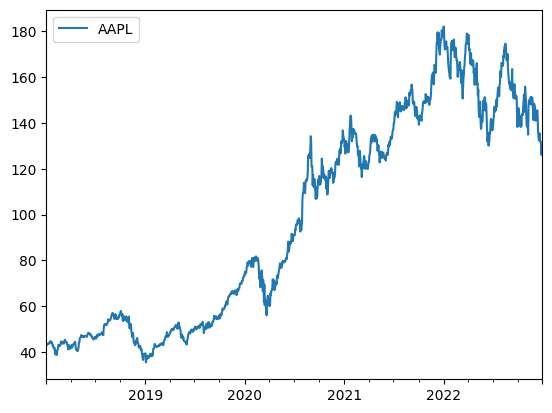

In [7]:
df.plot()
plt.show()

## Splitting the data:

**Computing the number of samples we'll use for each data split** 

In [8]:
len(df)

1304

In [9]:
num_train_samples = int(0.6 * len(df))
num_val_samples = int(0.20 * len(df))
num_test_samples = len(df) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 782
num_val_samples: 260
num_test_samples: 262


# Question 1: price data




# Preparing the data

## Stationarity



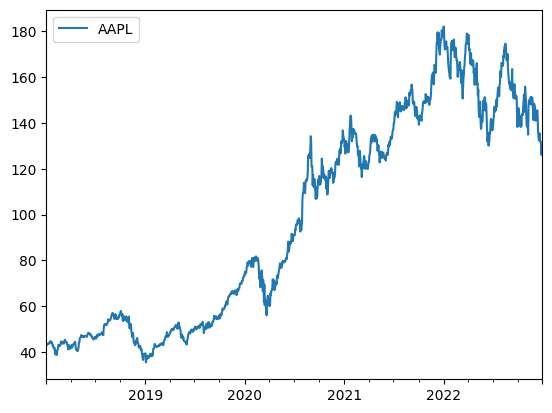

In [10]:
df.plot()
plt.show()

In [11]:
# the data is clearly not stationary. We will go ahead and use the log returns
df['LogAAPL']= np.log(df['AAPL'])
df['DiffLogAAPL']= df['LogAAPL'].diff(1)

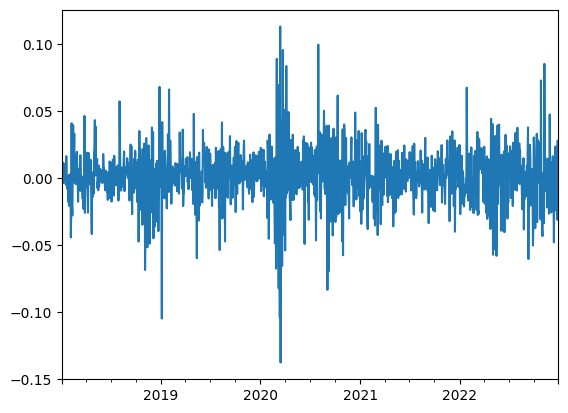

In [12]:
df['DiffLogAAPL'].plot()
plt.show()

In [13]:
df.dropna(inplace=True)

In [14]:
df.head()

,AAPL,LogAAPL,DiffLogAAPL
2018-01-03,43.057499,3.762536,-0.000174
2018-01-04,43.257500,3.767171,0.004634
2018-01-05,43.750000,3.778492,0.011321
2018-01-08,43.587502,3.774770,-0.003721
2018-01-09,43.582500,3.774656,-0.000115


In [15]:
(43.2575 - 43.057499)/43.057499

0.004644974850954542



## Normalizing the data

In [16]:
# in this example, because we work with stationary DiffLogPassengers, we don't need to normalize the data. If you want, you cant try running the following:

# mean = df[:num_train_samples].mean(axis=0)
# df -= mean
#std = df[:num_train_samples].std(axis=0)
# df /= std

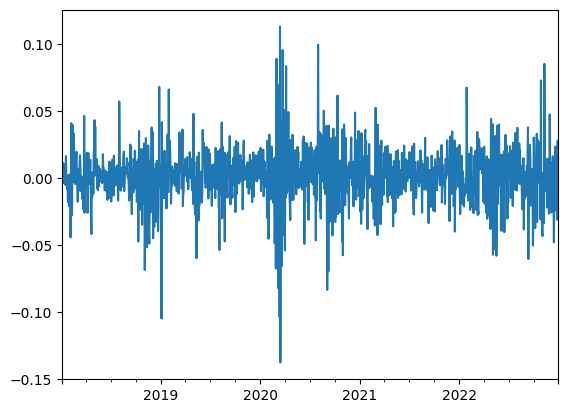

In [17]:
df['DiffLogAAPL'].plot()
plt.show()

## Time series batch generator
**Instantiating datasets for training, validation, and testing**
https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

In [18]:
# recall
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 782
num_val_samples: 260
num_test_samples: 262


In [19]:
import numpy as np
from tensorflow import keras

In [20]:
series = df['DiffLogAAPL']
sequence_length = 60 # using the past 60 days to predict next day. 
h = 1 
delay = sequence_length  + h - 1
batch_size = 32

train_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data = series[:-delay],
    targets=series[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [21]:
for inputs, targets in test_dataset.take(1):
  print(inputs, targets)

tf.Tensor(
[[-0.00138988 -0.02149863 -0.00939981 ...  0.00324786 -0.03375248
   0.01598362]
 [ 0.00011618  0.01664449  0.00256694 ... -0.00667175 -0.01793568
  -0.00171961]
 [-0.01912367 -0.01862313  0.00180247 ...  0.02134427  0.02422152
   0.        ]
 ...
 [ 0.01293974 -0.01819216  0.01603511 ... -0.01102066  0.02477353
   0.01554401]
 [ 0.00098787  0.00011618  0.01664449 ...  0.01895364 -0.00667175
  -0.01793568]
 [-0.02085926  0.02637112  0.01341944 ...  0.0020512  -0.00664774
  -0.03740977]], shape=(32, 60), dtype=float64) tf.Tensor(
[-0.05323336  0.02341711 -0.03024237  0.00521402  0.03933535 -0.03729154
 -0.02726248  0.00671461 -0.00087373  0.0011393   0.01146714  0.01866448
  0.02119931  0.         -0.00664774  0.          0.00502402 -0.02821555
 -0.0573285   0.04018979  0.0199119   0.03778503  0.          0.03226684
 -0.05807325 -0.03931861 -0.03740977  0.02530032  0.01603511 -0.02047585
 -0.00171961  0.00235287], shape=(32,), dtype=float64)


In [22]:
series.iloc[num_train_samples + num_val_samples:]

2021-12-31   -0.003542
2022-01-03    0.024697
2022-01-04   -0.012773
2022-01-05   -0.026960
2022-01-06   -0.016834
                ...   
2022-12-26    0.000000
2022-12-27   -0.013976
2022-12-28   -0.031166
2022-12-29    0.027931
2022-12-30    0.002466
Freq: B, Name: DiffLogAAPL, Length: 261, dtype: float64

In [23]:
for samples, targets in train_dataset.take(1):
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    

samples shape: (32, 60)
targets shape: (32,)


# A common-sense, non-machine-learning baseline

In [24]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1] 
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen


In [25]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.3f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.3f}")

# the unit is DiffLogPassengers

Validation MAE: 0.015
Test MAE: 0.026


# Simple RNN

In [26]:
from tensorflow.keras import layers

In [27]:
sequence_length

60

In [28]:
n_features = 1

In [37]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.SimpleRNN(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary() 


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [30]:
# parameters = (1 (feature) * 16 (cells) ) + (16 * 16) hidden state weight matrix + 16 bias terms
1*16 + 16*16 + 16

288

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint("RNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/20
23/23 [==============================] - 4s 54ms/step - loss: 0.0030 - mae: 0.0329 - val_loss: 3.1870e-04 - val_mae: 0.0139
Epoch 2/20
23/23 [==============================] - 1s 49ms/step - loss: 6.6726e-04 - mae: 0.0189 - val_loss: 2.3451e-04 - val_mae: 0.0119
Epoch 3/20
23/23 [==============================] - 2s 91ms/step - loss: 5.5494e-04 - mae: 0.0170 - val_loss: 4.2340e-04 - val_mae: 0.0175
Epoch 4/20
23/23 [==============================] - 1s 45ms/step - loss: 5.3525e-04 - mae: 0.0168 - val_loss: 3.9988e-04 - val_mae: 0.0169
Epoch 5/20
23/23 [==============================] - 1s 44ms/step - loss: 5.0788e-04 - mae: 0.0158 - val_loss: 2.3808e-04 - val_mae: 0.0121
Epoch 6/20
23/23 [==============================] - 1s 45ms/step - loss: 5.2211e-04 - mae: 0.0167 - val_loss: 4.2394e-04 - val_mae: 0.0176
Epoch 7/20
23/23 [==============================] - 1s 45ms/step - loss: 4.9605e-04 - mae: 0.0157 - val_loss: 3.1556e-04 - val_mae: 0.0147
Epoch 8/20
23/23 [=============

In [39]:
model = keras.models.load_model("RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.4f}")

5/5 [==============================] - 0s 10ms/step - loss: 5.0071e-04 - mae: 0.0174
Test MAE: 0.0174


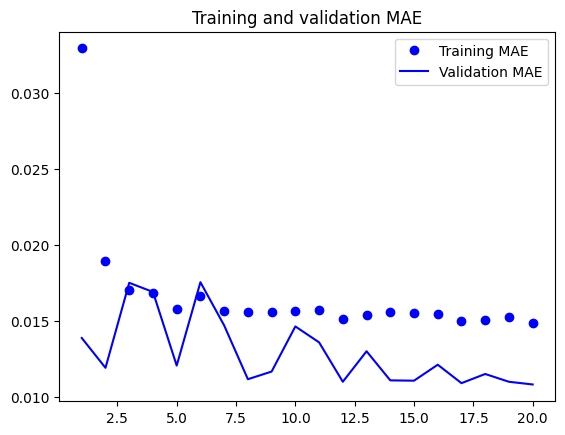

In [40]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

#  LSTM 

In [41]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary() 


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [36]:
# parameters = [(1 (feature) * 16 (cells) ) + (16 * 16) hidden state weight matrix + 16 bias terms ] * 4 gates
(1*16 + 16*16 + 16) *4

1152

In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint("LSTM.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/20
23/23 [==============================] - 7s 32ms/step - loss: 5.6705e-04 - mae: 0.0164 - val_loss: 1.8486e-04 - val_mae: 0.0105
Epoch 2/20
23/23 [==============================] - 0s 12ms/step - loss: 5.2734e-04 - mae: 0.0157 - val_loss: 2.5833e-04 - val_mae: 0.0129
Epoch 3/20
23/23 [==============================] - 0s 12ms/step - loss: 5.3307e-04 - mae: 0.0159 - val_loss: 3.1952e-04 - val_mae: 0.0147
Epoch 4/20
23/23 [==============================] - 0s 12ms/step - loss: 5.3775e-04 - mae: 0.0159 - val_loss: 2.1867e-04 - val_mae: 0.0116
Epoch 5/20
23/23 [==============================] - 0s 12ms/step - loss: 5.0847e-04 - mae: 0.0155 - val_loss: 1.8522e-04 - val_mae: 0.0106
Epoch 6/20
23/23 [==============================] - 0s 13ms/step - loss: 5.3710e-04 - mae: 0.0160 - val_loss: 1.8780e-04 - val_mae: 0.0105
Epoch 7/20
23/23 [==============================] - 0s 12ms/step - loss: 4.9858e-04 - mae: 0.0152 - val_loss: 1.8524e-04 - val_mae: 0.0106
Epoch 8/20
23/23 [=========

In [43]:
model = keras.models.load_model("LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")

5/5 [==============================] - 0s 5ms/step - loss: 5.0395e-04 - mae: 0.0172
Test MAE: 0.017


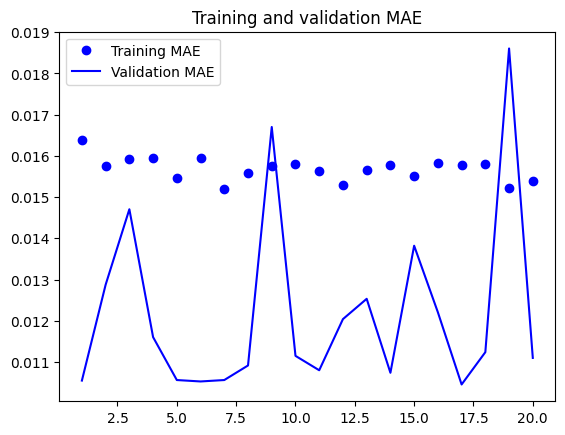

In [44]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# More complex models with regularization

In [45]:
# We can stack multiple LSTM layers and add regularization.  

inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.LSTM(128, recurrent_dropout=0.1, return_sequences=True)(inputs)
x = layers.SimpleRNN(128, recurrent_dropout=0.1)(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("RNN_LSTM_stacked_regularized.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/20
23/23 [==============================] - 12s 366ms/step - loss: 0.0480 - mae: 0.1698 - val_loss: 8.8494e-04 - val_mae: 0.0270
Epoch 2/20
23/23 [==============================] - 8s 334ms/step - loss: 0.0075 - mae: 0.0599 - val_loss: 1.8788e-04 - val_mae: 0.0107
Epoch 3/20
23/23 [==============================] - 7s 297ms/step - loss: 0.0013 - mae: 0.0277 - val_loss: 2.6697e-04 - val_mae: 0.0131
Epoch 4/20
23/23 [==============================] - 7s 282ms/step - loss: 7.9050e-04 - mae: 0.0207 - val_loss: 2.5862e-04 - val_mae: 0.0130
Epoch 5/20
23/23 [==============================] - 8s 352ms/step - loss: 7.1131e-04 - mae: 0.0197 - val_loss: 2.1087e-04 - val_mae: 0.0113
Epoch 6/20
23/23 [==============================] - 8s 331ms/step - loss: 7.1309e-04 - mae: 0.0194 - val_loss: 2.2310e-04 - val_mae: 0.0117
Epoch 7/20
23/23 [==============================] - 6s 269ms/step - loss: 6.6682e-04 - mae: 0.0188 - val_loss: 1.8635e-04 - val_mae: 0.0106
Epoch 8/20
23/23 [=============

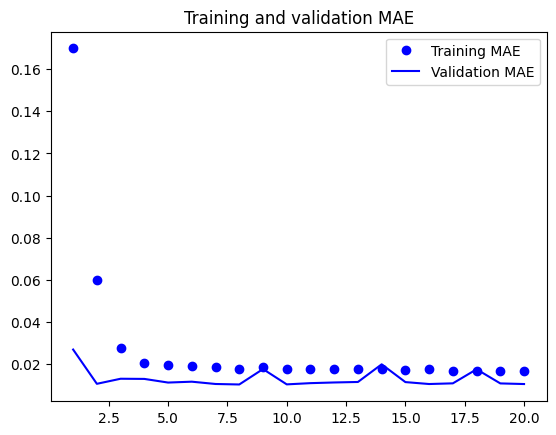

In [46]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [47]:
model = keras.models.load_model("RNN_LSTM_stacked_regularized.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")


5/5 [==============================] - 1s 26ms/step - loss: 4.9218e-04 - mae: 0.0170
Test MAE: 0.017


# Bidirectional RNN? 

In [49]:
inputs = keras.Input(shape=(sequence_length, n_features))
x = layers.Bidirectional(layers.SimpleRNN(32))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("bidirectional_RNN.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset, 
                    callbacks=callbacks)

Epoch 1/20
23/23 [==============================] - 5s 92ms/step - loss: 0.0033 - mae: 0.0356 - val_loss: 4.5484e-04 - val_mae: 0.0166
Epoch 2/20
23/23 [==============================] - 2s 82ms/step - loss: 7.8426e-04 - mae: 0.0205 - val_loss: 2.8565e-04 - val_mae: 0.0132
Epoch 3/20
23/23 [==============================] - 2s 80ms/step - loss: 7.4149e-04 - mae: 0.0204 - val_loss: 3.3676e-04 - val_mae: 0.0147
Epoch 4/20
23/23 [==============================] - 3s 123ms/step - loss: 6.6156e-04 - mae: 0.0189 - val_loss: 2.5109e-04 - val_mae: 0.0124
Epoch 5/20
23/23 [==============================] - 3s 110ms/step - loss: 6.3577e-04 - mae: 0.0179 - val_loss: 2.7097e-04 - val_mae: 0.0126
Epoch 6/20
23/23 [==============================] - 2s 97ms/step - loss: 6.0563e-04 - mae: 0.0178 - val_loss: 2.5976e-04 - val_mae: 0.0127
Epoch 7/20
23/23 [==============================] - 2s 77ms/step - loss: 5.6940e-04 - mae: 0.0173 - val_loss: 2.8361e-04 - val_mae: 0.0137
Epoch 8/20
23/23 [===========

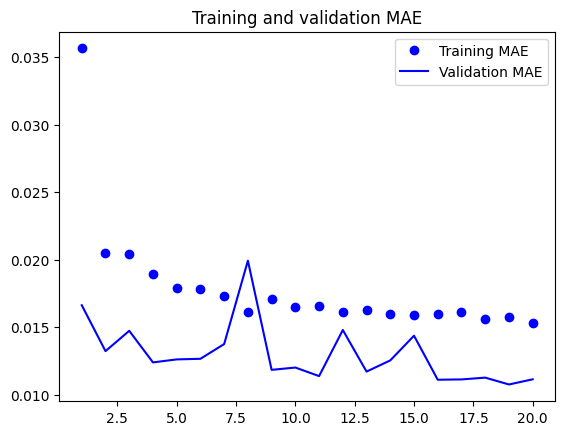

In [50]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [51]:
model = keras.models.load_model("bidirectional_RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.3f}")


5/5 [==============================] - 0s 12ms/step - loss: 5.3248e-04 - mae: 0.0181
Test MAE: 0.018


In [54]:
model = keras.models.load_model("RNN.keras")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [3]:
import numpy as np
new = np.arange(60)
new = new.reshape(1,60,1)
new.shape

(1, 60, 1)

In [4]:
model.predict(new)

NameError: ignored

# Done!